# 时序图展示

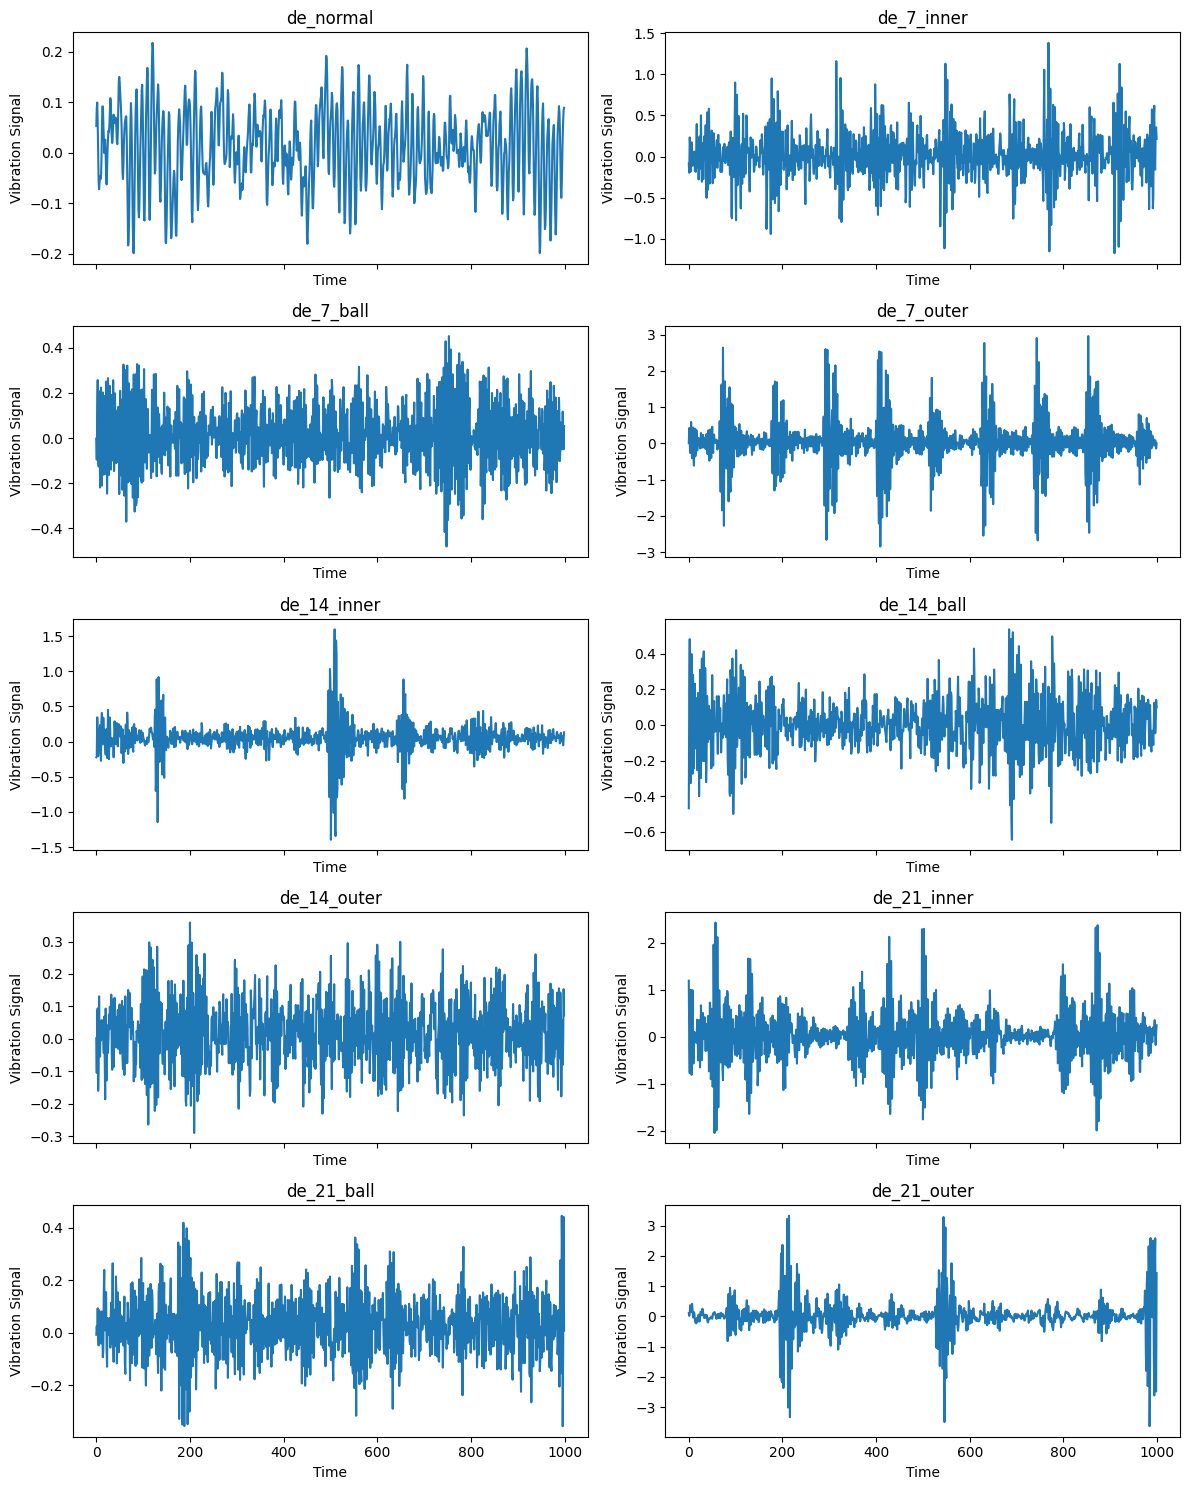

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
 
 
# 读取CSV文件的前1000行
df = pd.read_csv('CWRU10分类数据/data_12k_1797_10c.csv', nrows=1000)
 
# 获取列名
columns = df.columns
 
# 设置子图布局
fig, axs = plt.subplots(5, 2, figsize=(12, 15), sharex=True)
 
# 将列名按顺序分配给子图
for i in range(5):
    for j in range(2):
        index = i * 2 + j
        if index < len(columns):
            axs[i, j].plot(df[columns[index]])
            axs[i, j].set_title(columns[index])
            axs[i, j].set_xlabel('Time')
            axs[i, j].set_ylabel('Vibration Signal')
 
plt.savefig('my_sequence_plot.png')
            
# 调整布局
plt.tight_layout()

# 数据预处理

In [1]:
import pandas as pd
import numpy as np
 
# 读取 CSV 文件
df = pd.read_csv('CWRU10分类数据/data_12k_1797_10c.csv')
 
# 定义信号间隔长度和每块样本点数
interval_length = 1024
samples_per_block = 1024
 
 
# 数据前处理函数
def Sampling(signal, interval_length, samples_per_block):
    num_samples = len(signal)
    num_blocks = num_samples // samples_per_block
    samples = []
    for i in range(num_blocks):
        start = i * samples_per_block
        end = start + interval_length
        samples.append(signal[start:end])
    return np.array(samples)
 
def DataPreparation(df, interval_length, samples_per_block):
    X, LabelPositional, Label = None, None, None
    for count, column in enumerate(df.columns):
        SplitData = Sampling(df[column].values, interval_length, samples_per_block)
        y = np.zeros([len(SplitData), 10])
        y[:, count] = 1
        y1 = np.zeros([len(SplitData), 1])
        y1[:, 0] = count
        # 堆叠并标记数据
        if X is None:
            X = SplitData
            LabelPositional = y
            Label = y1
        else:
            X = np.append(X, SplitData, axis=0)
            LabelPositional = np.append(LabelPositional, y, axis=0)
            Label = np.append(Label, y1, axis=0)
    return X, LabelPositional, Label
 
# 数据前处理
X, Y_CNN, Y = DataPreparation(df, interval_length, samples_per_block)
 
print('Shape of Input Data =', X.shape)
print('Shape of Label Y_CNN =', Y_CNN.shape)
print('Shape of Label Y =', Y.shape)

Shape of Input Data = (1170, 1024)
Shape of Label Y_CNN = (1170, 10)
Shape of Label Y = (1170, 1)


## cnn-transformer 交叉验证

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
import numpy as np

# CNN需要的输入格式 [样本数, 时间步长, 特征维度]
Input_1D = X.reshape([-1, 1024, 1])
X_train_val, X_test, y_train_val, y_test = train_test_split(
    Input_1D, Y_CNN, 
    test_size=0.1, 
    random_state=101
) # 9:1 划分

class CNN_Transformer:
    def __init__(self):
        self.model = self.create_model()
    
    @staticmethod
    def transformer_encoder(inputs, num_heads, key_dim, ff_dim, dropout=0.1):
        # 多头自注意力
        attn = layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=key_dim
        )(inputs, inputs)
        attn = layers.Dropout(dropout)(attn)
        res = layers.Add()([inputs, attn])
        res = layers.LayerNormalization()(res)
        
        # 前馈网络
        ff = layers.Dense(ff_dim, activation="relu")(res)
        ff = layers.Dense(inputs.shape[-1])(ff)
        ff = layers.Dropout(dropout)(ff)
        out = layers.Add()([res, ff])
        return layers.LayerNormalization()(out)
    
    def create_model(self):
        inputs = layers.Input(shape=(1024, 1))
        
        # 两层卷积
        x = layers.Conv1D(16, 5, strides=2, activation="relu")(inputs)
        x = layers.MaxPool1D(2)(x)
        x = layers.Conv1D(32, 3, strides=2, activation="relu")(x)
        x = layers.MaxPool1D(2)(x)
        
        # Transformer
        x = self.transformer_encoder(
            x, 
            num_heads=4,
            key_dim=8,
            ff_dim=64,
            dropout=0.1
        )
        
        # 分类器
        x = layers.GlobalAveragePooling1D()(x)
        x = layers.Dense(100, activation="relu")(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(50, activation="relu")(x)
        outputs = layers.Dense(10, activation="softmax")(x)
        
        model = models.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer="adam",
            loss="categorical_crossentropy",
            metrics=["accuracy"]
        )
        return model

# 5折交叉验证
kfold = KFold(n_splits=5, shuffle=True, random_state=101)
cv_accuracy = []
fold_history = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_val, y_train_val)):
    print(f"\n{'='*40}")
    print(f"训练折数 {fold+1}/{kfold.n_splits}")
    
    # 数据划分
    X_train_fold = X_train_val[train_idx]
    y_train_fold = y_train_val[train_idx]
    X_val_fold = X_train_val[val_idx]
    y_val_fold = y_train_val[val_idx]
    
    model = CNN_Transformer().model
    
    callbacks = [
        EarlyStopping(
            monitor="val_accuracy",
            patience=15,
            restore_best_weights=True
        ), # 早停回调
        ModelCheckpoint(
            f"model_fold{fold+1}.keras",
            monitor="val_accuracy",
            save_best_only=True,
            mode="max",
            verbose=1 
        ) # 模型检查点回调
    ]
    
    # 训练
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=30,
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )
    fold_history.append(history.history)
    
    # 得到最佳模型
    best_model = tf.keras.models.load_model(
        f"model_fold{fold+1}.keras",
    )
    _, val_acc = best_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    cv_accuracy.append(val_acc)
    print(f"\n{fold+1}折 验证精度: {val_acc*100:.2f}%")


print(f"\n{'='*40}")
print("交叉验证结果：")
print(f"平均验证精度：{np.mean(cv_accuracy)*100:.2f}%")
print(f"标准偏差：±{np.std(cv_accuracy)*100:.2f}%")

# 完整训练
print("\n开始完整训练")
final_model = CNN_Transformer().model

callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=15,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "final_model.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode="max",
        verbose=1 
    )
]

# 保留最佳模型
final_model.fit(
    X_train_val, y_train_val,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=0
)

# final_model.fit(
#     X_train_val, y_train_val,
#     epochs=25,
#     batch_size=32,
#     verbose=0
# )
# final_model.save("final_model.keras")

# 测试集上验证
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\n{'='*40}")
print(f"最终模型测试集精度：{test_acc*100:.2f}%")


训练折数 1/5

Epoch 1: val_accuracy improved from -inf to 0.38389, saving model to model_fold1.keras

Epoch 2: val_accuracy improved from 0.38389 to 0.73934, saving model to model_fold1.keras

Epoch 3: val_accuracy improved from 0.73934 to 0.89100, saving model to model_fold1.keras

Epoch 4: val_accuracy improved from 0.89100 to 0.93839, saving model to model_fold1.keras

Epoch 5: val_accuracy did not improve from 0.93839

Epoch 6: val_accuracy improved from 0.93839 to 0.97156, saving model to model_fold1.keras

Epoch 7: val_accuracy improved from 0.97156 to 0.97630, saving model to model_fold1.keras

Epoch 8: val_accuracy did not improve from 0.97630

Epoch 9: val_accuracy did not improve from 0.97630

Epoch 10: val_accuracy did not improve from 0.97630

Epoch 11: val_accuracy did not improve from 0.97630

Epoch 12: val_accuracy improved from 0.97630 to 0.98104, saving model to model_fold1.keras

Epoch 13: val_accuracy did not improve from 0.98104

Epoch 14: val_accuracy did not improve 

# 可视化

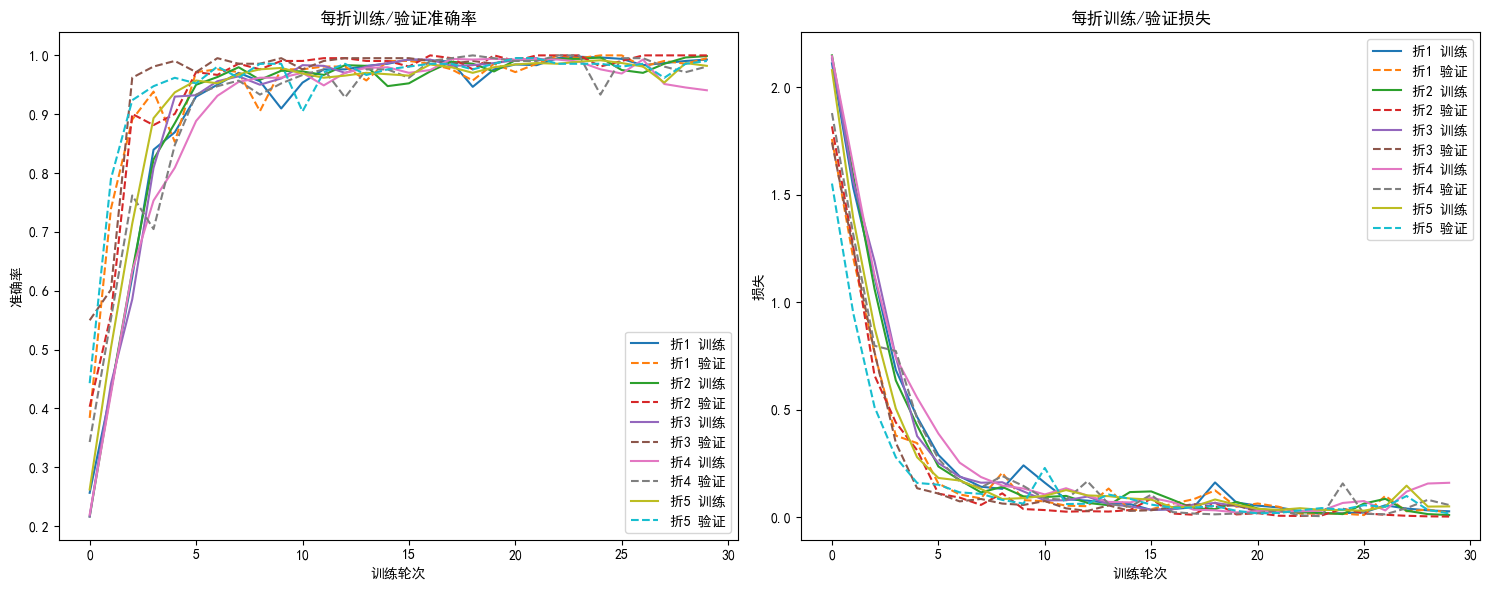

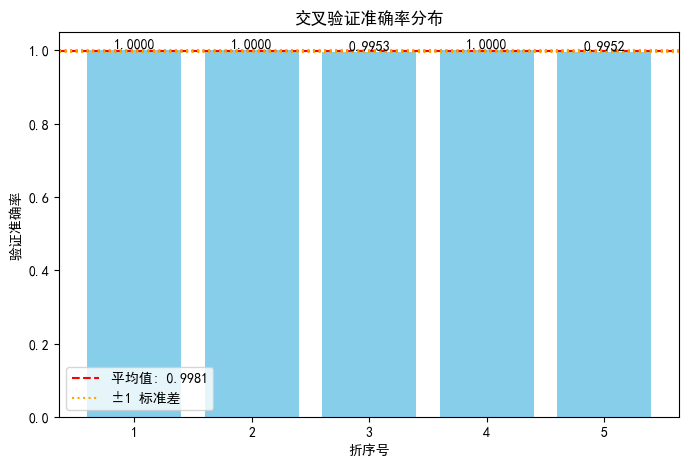

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


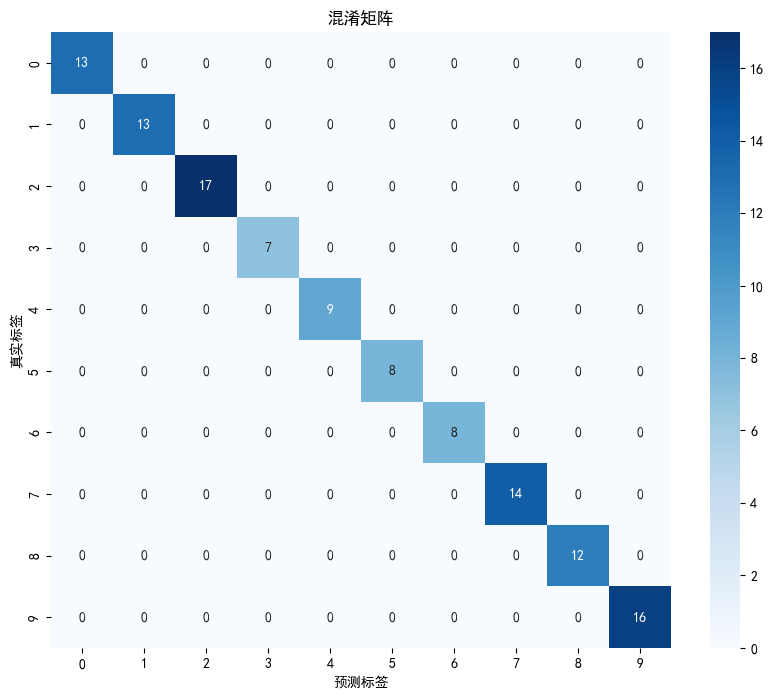


分类报告:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        13
           1     1.0000    1.0000    1.0000        13
           2     1.0000    1.0000    1.0000        17
           3     1.0000    1.0000    1.0000         7
           4     1.0000    1.0000    1.0000         9
           5     1.0000    1.0000    1.0000         8
           6     1.0000    1.0000    1.0000         8
           7     1.0000    1.0000    1.0000        14
           8     1.0000    1.0000    1.0000        12
           9     1.0000    1.0000    1.0000        16

    accuracy                         1.0000       117
   macro avg     1.0000    1.0000    1.0000       117
weighted avg     1.0000    1.0000    1.0000       117



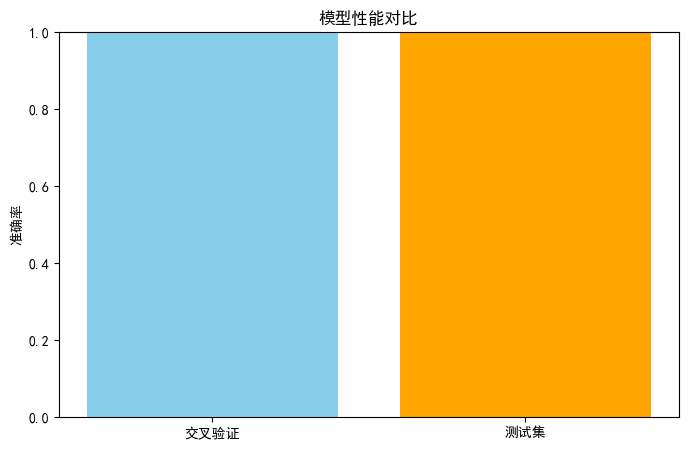

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False    

# ======================
# 交叉验证结果可视化
# ======================
# 各fold训练过程曲线
plt.figure(figsize=(15, 6))

# 准确率曲线
plt.subplot(1, 2, 1)
for i, history in enumerate(fold_history):
    plt.plot(history['accuracy'], label=f'折{i+1} 训练')
    plt.plot(history['val_accuracy'], '--', label=f'折{i+1} 验证')
plt.title('每折训练/验证准确率')
plt.xlabel('训练轮次')
plt.ylabel('准确率')
plt.legend()

# 损失曲线
plt.subplot(1, 2, 2)
for i, history in enumerate(fold_history):
    plt.plot(history['loss'], label=f'折{i+1} 训练')
    plt.plot(history['val_loss'], '--', label=f'折{i+1} 验证')
plt.title('每折训练/验证损失')
plt.xlabel('训练轮次')
plt.ylabel('损失')
plt.legend()
plt.tight_layout()
plt.show()

# 交叉验证准确率分布
plt.figure(figsize=(8, 5))
bars = plt.bar(range(1, 6), cv_accuracy, color='skyblue')
plt.axhline(np.mean(cv_accuracy), color='r', linestyle='--', 
            label=f'平均值: {np.mean(cv_accuracy):.4f}')
plt.axhline(np.mean(cv_accuracy)+np.std(cv_accuracy), color='orange', 
            linestyle=':', label='±1 标准差')
plt.axhline(np.mean(cv_accuracy)-np.std(cv_accuracy), color='orange', linestyle=':')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom')

plt.title('交叉验证准确率分布')
plt.xlabel('折序号')
plt.ylabel('验证准确率')
plt.xticks(range(1, 6))
plt.legend()
plt.show()

# ======================
# 测试集结果可视化
# ======================
# 预测测试集
y_pred = final_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 混淆矩阵
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('混淆矩阵')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.show()

# 分类报告
print("\n分类报告:")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

# 准确率对比
plt.figure(figsize=(8, 5))
plt.bar(['交叉验证', '测试集'], 
        [np.mean(cv_accuracy), test_acc],
        color=['skyblue', 'orange'])
plt.ylim(0, 1)
plt.title('模型性能对比')
plt.ylabel('准确率')
plt.show()